In [29]:
# cspell:disable

# Download dataset

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/vivek468/beginner-chest-xray-image-classification?select=chest_xray')


100%|██████████| 2.08G/2.08G [33:17<00:00, 1.12MB/s]


Only run code from this downward!!!!!!!!

Preprocessing for direct evaluation

Sharpening + Contrast 1: Black to White, White to back

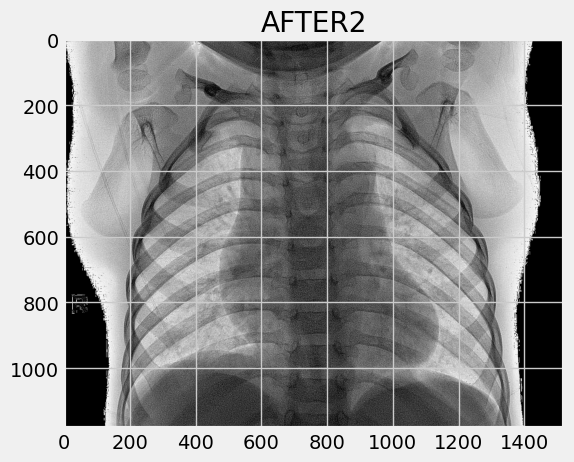

In [34]:
# cspell:disable
# Image reprocessing
import cv2
import numpy as np

# Function to map each intensity level to output intensity level.
def filter(pic):

    img = pic.astype('int16')

    # Define parameters.
    r1 = 128
    s1 = 0
    r2 = 224
    s2 = 255
    
    # Create kernel for sharpening
    kernel1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

     # Contrast function
    def pixelVal(pix, r1, s1, r2, s2):
        if isinstance(pix, np.ndarray):
            mask1 = np.logical_and(pix >= 0, pix <= r1)
            mask2 = np.logical_and(pix > r1, pix <= r2)
            mask3 = np.logical_and(pix > r2, pix <= 255)
            new_pix = np.zeros(pix.shape)
            new_pix[mask1] = (s1 / r1)*pix[mask1]
            new_pix[mask2] = ((s2 - s1)/(r2 - r1)) * (pix[mask2] - r1) + s1
            new_pix[mask3] = ((255 - s2)/(255 - r2)) * (pix[mask3] - r2) + s2
            return new_pix
        else:
            if (0 <= pix and pix <= r1):
                return (s1 / r1)*pix
            elif (r1 < pix and pix <= r2):
                return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
            elif (r2 < pix and pix <= 255):
                return ((255 - s2)/(255 - r2)) * (pix - r2) + s2
            
    # Apply kernel
    img = cv2.filter2D(pic, -1, kernel1)

  
    # Apply the contrast function
    pixelVal(img, r1, s1, r2, s2)
 
    return img  

# Display image
import matplotlib.pyplot as plt
img = cv2.imread(r'D:\IU\BIP_lab\beginner-chest-xray-image-classification\chest_xray\pred\NORMAL\NORMAL_1.jpeg', 0)

# AFTER APPLY THE FILTER
img = filter(img)

img = (img*255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.title('AFTER2')
plt.imshow(img)
plt.show()



Sharpening, contrast 2: Contrast sketching

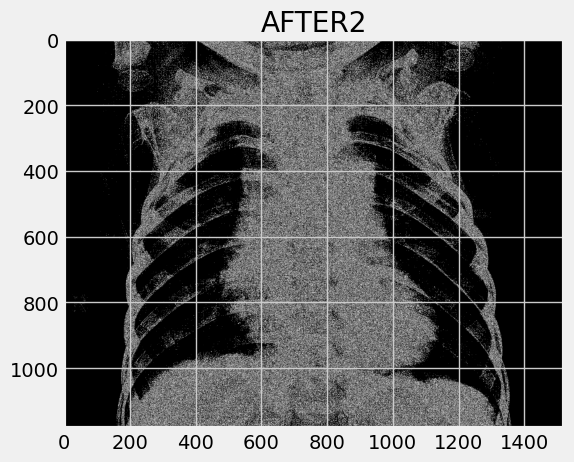

In [29]:
# cspell:disable
# Image reprocessing
import cv2
import numpy as np

# Function to map each intensity level to output intensity level.
def filter(pic):

    img = pic.astype('int16')

    # Define parameters.
    r1 = 128
    s1 = 0
    r2 = 224
    s2 = 255
    
    # Create kernel for sharpening
    kernel1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

     # Contrast function
    def pixelVal(pix, r1, s1, r2, s2):
        if (0 <= pix and pix <= r1):
            return (s1 / r1)*pix
        elif (r1 < pix and pix <= r2):
            return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
        else:
            return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

    # Apply kernel
    img = cv2.filter2D(pic, -1, kernel1)

  
    # Apply the contrast function
    pixelVal_vec = np.vectorize(pixelVal)
    img = pixelVal_vec(img, r1, s1, r2, s2)
 
    return img  

# Display image
import matplotlib.pyplot as plt
img = cv2.imread(r'D:\IU\BIP_lab\beginner-chest-xray-image-classification\chest_xray\pred\NORMAL\NORMAL_1.jpeg', 0)

# AFTER APPLY THE FILTER
img = filter(img)

img = (img*255).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
plt.title('AFTER2')
plt.imshow(img)
plt.show()



CNN ROUTINE !!!!!!!!!!!!!

LIBRARY

In [35]:
# cspell:disable
# Importing OS and Pathlib, so that we can work with files in our directories/PC
import os
import pathlib

# Some basic libraries that help us create dataframes and visualizations.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
plt.style.use("fivethirtyeight")

# Deep Learning Libraries like Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Flatten

# Shows the Tensorflow and Keras Version
print("Tensorflow Version:", tf.__version__)
print("Keras Version:", keras.__version__)

# To Suppress any Un-necessary warnings
import warnings
warnings.filterwarnings('ignore')

Tensorflow Version: 2.12.0
Keras Version: 2.12.0


SET DIRECTORY

In [2]:
# Get data
# Here, we define the paths where we have our data for training, testing and predictions
data_dir_train = pathlib.Path(r'D:\IU\BIP_lab\beginner-chest-xray-image-classification\chest_xray\train')
data_dir_test = pathlib.Path(r'D:\IU\BIP_lab\beginner-chest-xray-image-classification\chest_xray\test')
data_dir_val = pathlib.Path(r'D:\IU\BIP_lab\beginner-chest-xray-image-classification\chest_xray\pred')

OVERVIEW OF OUR DATASET

In [3]:
# Check number of images
# Checking the number images in all the paths defined above
print("Number of Images in Train:", len(list(data_dir_train.glob("*/*.jpeg"))))
print("Number of Images in Test:", len(list(data_dir_test.glob("*/*.jpeg"))))
print("Number of Images in Validation:", len(list(data_dir_val.glob("*/*.jpeg"))))

Number of Images in Train: 7315
Number of Images in Test: 620
Number of Images in Validation: 9


DEFINE CNN PARAMETERS

In [4]:
# Define some parameters
# Here, we are defining some variables which will be commonly used in the further codes
height = 150
width = 150
batch_size = 16
seed = 42 # For reproducibility 

CREATE A DATASET FROM OUR FOLDERS

CREATE TRAIN DATASET FOR ORIGINAL DATA

In [5]:
# Next! In this step, we are going to use the method "image_dataset_from_directory()" to construct a dataset!

# First we ask Keras to create a "training" dataset with 0.2 as validation split.

train_ds = keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=seed,
validation_split=0.2,
subset='training',
image_size=(height,width),
batch_size=batch_size)

Found 7315 files belonging to 2 classes.
Using 5852 files for training.


CREATE VALUATION DATASET FOR ORIGINAL DATA

In [11]:
# Second we ask Keras to create a "validation" dataset with 0.2 as validation split.

val_ds = keras.preprocessing.image_dataset_from_directory(
data_dir_train,
seed=seed,
validation_split=0.2,
subset='validation',
image_size=(height,width),
batch_size=batch_size)

Found 7315 files belonging to 2 classes.
Using 1463 files for validation.


CREATE TRAIN DATASET FOR FILTERED DATA

DEFINE FUNCTION FOR THE FILTER

In [6]:
# REPROCESSING ALGORITHM
import cv2
def filter(pic):

    img = pic.astype('int16')

    # Define parameters.
    r1 = 128
    s1 = 0
    r2 = 224
    s2 = 255
    
    # Create kernel for sharpening
    kernel1 = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])

     # Contrast function
    def pixelVal(pix, r1, s1, r2, s2):
        if isinstance(pix, np.ndarray):
            mask1 = np.logical_and(pix >= 0, pix <= r1)
            mask2 = np.logical_and(pix > r1, pix <= r2)
            mask3 = np.logical_and(pix > r2, pix <= 255)
            new_pix = np.zeros(pix.shape)
            new_pix[mask1] = (s1 / r1)*pix[mask1]
            new_pix[mask2] = ((s2 - s1)/(r2 - r1)) * (pix[mask2] - r1) + s1
            new_pix[mask3] = ((255 - s2)/(255 - r2)) * (pix[mask3] - r2) + s2
            return new_pix
        else:
            if (0 <= pix and pix <= r1):
                return (s1 / r1)*pix
            elif (r1 < pix and pix <= r2):
                return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
            elif (r2 < pix and pix <= 255):
                return ((255 - s2)/(255 - r2)) * (pix - r2) + s2
            
    # Apply kernel
    img = cv2.filter2D(pic, -1, kernel1)

  
    # Apply the contrast function
    pixelVal(img, r1, s1, r2, s2)
 
    return img

CREATE TRAIN DATASET WITH FILTERED IMAGES

In [7]:
# APPLY REPROCESSING TO DATASET
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the function that will be used to process the images.
def process_image(image):
    # Convert the image pixels to numpy array.
    image = np.array(image)
    # Apply the contrast function to the image.
    image = filter(image)
    # Return the processed image.
    return image

# Create an instance of the ImageDataGenerator.
data_generator = ImageDataGenerator(preprocessing_function=process_image, validation_split=0.2)

# Create the image dataset from the directory.
train_ds = data_generator.flow_from_directory(
    data_dir_train,
    seed=seed,
    subset='training',
    target_size=(height,width),
    batch_size=batch_size,
    class_mode = 'binary'
)

val_ds = data_generator.flow_from_directory(
    data_dir_train,
    seed=seed,
    subset='validation',
    target_size=(height,width),
    batch_size=batch_size,
    class_mode = 'binary'
)




Found 5853 images belonging to 2 classes.
Found 1462 images belonging to 2 classes.


CREATE TEST DATASET WITH FILTERED IMAGES

In [8]:
test_ds = data_generator.flow_from_directory(
    data_dir_test,
    seed=seed,
    subset='validation',
    target_size=(height,width),
    batch_size=batch_size,
    class_mode='binary'    
)

Found 123 images belonging to 2 classes.


CREATE PREDICT DATASET WITH FILTERED IMAGES (IF U WANT)

Check the label (Use with ORIGINAL DATA ONLY)

In [19]:
# Finally we are storing all the available class names from the dataset. (NORMAL and PNEUMONIA)

# This also ensures, we have created the dataset successfully!

class_names = train_ds.class_names
class_names

AttributeError: 'DirectoryIterator' object has no attribute 'class_names'

Plot the images with label (USE WITH ORIGINAL DATA)

In [50]:
# Defining the Canvas size
plt.figure(figsize=[10,8])

# Next we are just picking one image from the unique categories and displaying them:
for index, classes in enumerate(class_names):
    for images in train_ds.file_paths:
        if classes in images:
            img = image.imread(images)
            plt.subplot(1,2,index+1)
            plt.imshow(img, cmap=plt.cm.gist_gray)
            plt.xticks([])
            plt.yticks([])
            plt.title(str(classes))
            break
plt.show()

NameError: name 'class_names' is not defined

<Figure size 1000x800 with 0 Axes>

BUILD CNN MODEL


Structure CNN

In [10]:
# Here we start building our model in Keras:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(height, width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(2)
])

Compile model

In [12]:
# Next we compile this model where we define the optimizer, loss function and the metric which we will use to evaluate.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Visualize model

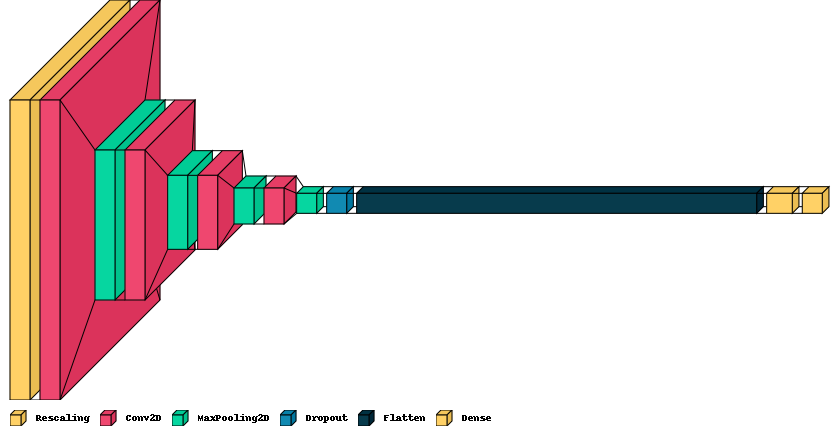

In [53]:
# Visualizing our model (Hidden Input)
import visualkeras
visualkeras.layered_view(model, scale_xy=2, legend=True)

TRAIN MODEL

In [13]:
# Finally we are going to train our model for 20 epochs
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
366/366 [==============================] - 128s 347ms/step - loss: 0.2494 - accuracy: 0.9050 - val_loss: 0.1032 - val_accuracy: 0.9692
Epoch 2/20
366/366 [==============================] - 125s 342ms/step - loss: 0.1495 - accuracy: 0.9453 - val_loss: 0.0836 - val_accuracy: 0.9740
Epoch 3/20
366/366 [==============================] - 113s 308ms/step - loss: 0.1154 - accuracy: 0.9568 - val_loss: 0.0678 - val_accuracy: 0.9747
Epoch 4/20
366/366 [==============================] - 104s 285ms/step - loss: 0.0918 - accuracy: 0.9675 - val_loss: 0.0596 - val_accuracy: 0.9822
Epoch 5/20
366/366 [==============================] - 111s 303ms/step - loss: 0.0777 - accuracy: 0.9706 - val_loss: 0.0409 - val_accuracy: 0.9856
Epoch 6/20
366/366 [==============================] - 126s 344ms/step - loss: 0.0637 - accuracy: 0.9756 - val_loss: 0.0454 - val_accuracy: 0.9836
Epoch 7/20
366/366 [==============================] - 102s 280ms/step - loss: 0.0471 - accuracy: 0.9815 - val_loss: 0.0582 -

EVALUATION FROM THIS BELOW!!!!!!!

MODEL 1 (original images)

Plot history

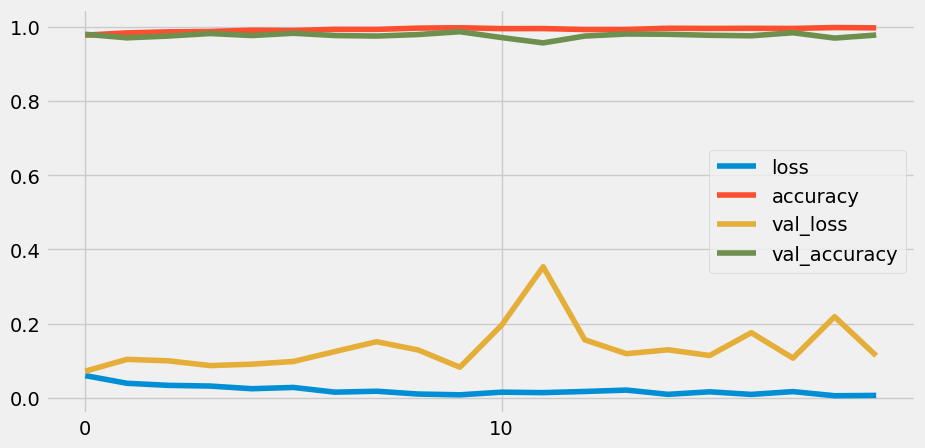

In [109]:

pd.DataFrame(history.history).plot(figsize=[10,5])
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,10,2))
plt.show()

Performance on Test dataset

In [23]:
# Model 1 TEST
model1= keras.models.load_model("./xray_model.h5")
model1.evaluate(test_ds, batch_size=batch_size)

39/39 [==============================] - 4s 81ms/step - loss: 0.2232 - accuracy: 0.9597


[0.22323352098464966, 0.9596773982048035]

Save model 1

In [15]:
# The Next step is to save the model. This is our trained model. We saved it so that we do not need to train it again and again.

# I am saving this in the .h5 format.

model.save("./xray_model3(CONTRASTGPT+NET).h5")

MODEL 2 (SHARPENING + NORMALIZE)

Plot history

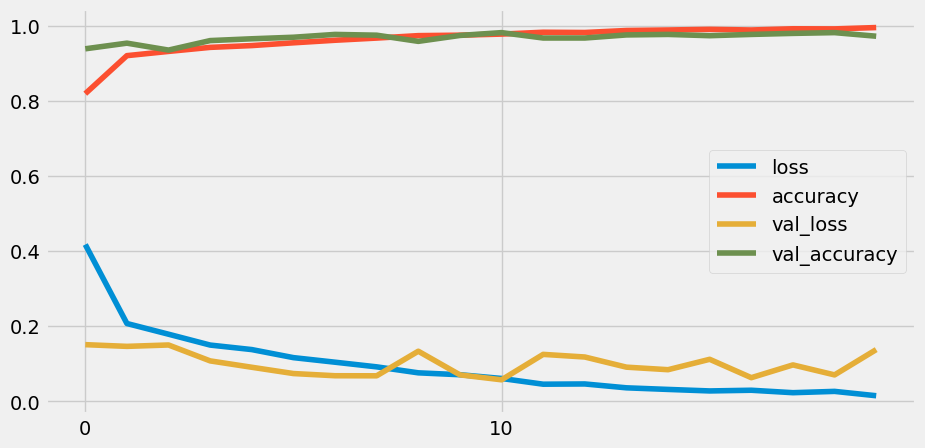

In [63]:
# Next we are going to plot a graph to check the loss and accuracy as the model trained for 20 epochs for both train and validation.
import pandas as pd
pd.DataFrame(history.history).plot(figsize=[10,5])
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,10,2))
plt.show()

Performance on TEST dataset

In [20]:
# Model 2 TEST
model2 = keras.models.load_model("./xray_model2.h5")
model2.evaluate(test_ds, batch_size=batch_size)


8/8 [==============================] - 2s 208ms/step - loss: 0.4906 - accuracy: 0.9512


[0.4905881881713867, 0.9512194991111755]

Save model

In [ ]:
model.save("./xray_model3(SHARPENING+NORMALIZE).h5")

MODEL 3 (CONTRAST + SHARPENING)

Plot history

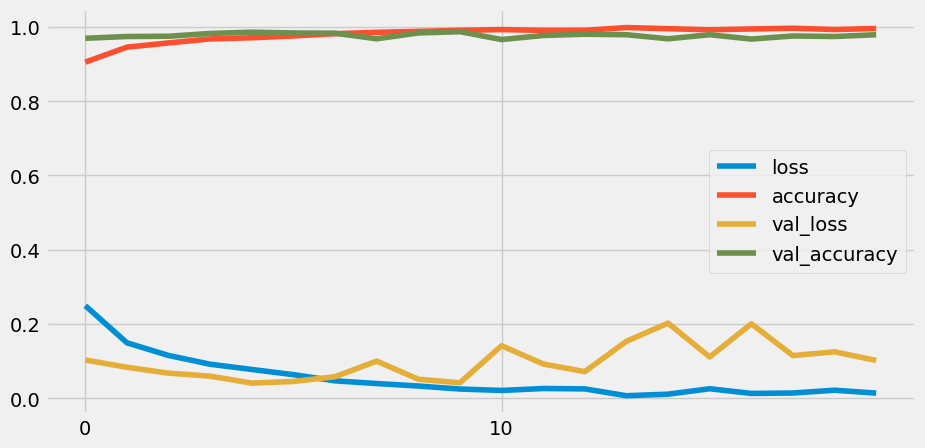

In [14]:

pd.DataFrame(history.history).plot(figsize=[10,5])
plt.yticks(np.linspace(0,1,6))
plt.xticks(np.linspace(0,10,2))
plt.show()

Performance on TEST dataset

In [18]:
# Model 2 TEST
model3 = keras.models.load_model("./xray_model3(CONTRASTGPT+NET).h5")
model3.evaluate(test_ds, batch_size=batch_size)


8/8 [==============================] - 1s 120ms/step - loss: 0.1928 - accuracy: 0.9675


[0.1928168684244156, 0.9674796462059021]

Save model

In [ ]:
model.save("./xray_model3(CONTRASTGPT+NET).h5")

GỌI MODEL PREDICT

1/1 [==============================] - 0s 69ms/step


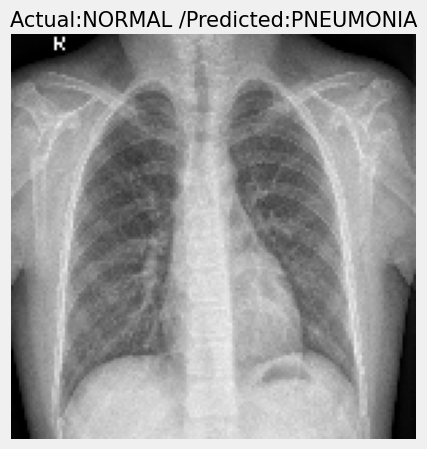

In [77]:
# Loading the .h5 model that we had saved in the previous step:
my_xray_cnnmodel = keras.models.load_model("./xray_model2.h5")

# Defining an image path from the "pred" folder:
image_path = r'D:\IU\BIP_lab\beginner-chest-xray-image-classification\chest_xray\pred\NORMAL\NORMAL_2.jpeg'

# Preprocessing the image to 150x150x3 size and predicting the label:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(150,150,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])
predictions = my_xray_cnnmodel.predict(input_arr)

classes = ['NORMAL', 'PNEUMONIA']

actual = ''

for class_name in classes:
    if class_name in image_path:
        actual = class_name

pred = classes[np.argmax(predictions, axis=1)[0]]

# Finally we are displaying the predicted outcome:
plt.figure(figsize=[8,5])
plt.imshow(image, cmap='gray')
plt.title("Actual:"+actual+" /Predicted:"+pred, size=15)
plt.axis('off')
plt.show()